# Aligning low-resolution brain volumes of 2 individuals with fMRI data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets, image, plotting
from nilearn.image import get_data

In [2]:
n_subjects = 2

contrasts = [
    "sentence reading vs checkerboard",
    "sentence listening",
    "calculation vs sentences",
    "left vs right button press",
    "checkerboard",
]
n_training_contrasts = 4

brain_data = datasets.fetch_localizer_contrasts(
    contrasts,
    n_subjects=n_subjects,
    get_anats=True,
)

source_imgs_paths = brain_data["cmaps"][0 : len(contrasts)]
target_imgs_paths = brain_data["cmaps"][len(contrasts) : 2 * len(contrasts)]

/opt/homebrew/lib/python3.11/site-packages/nilearn/datasets/func.py:763: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


In [3]:
#plotting.plot_stat_map(image.index_img(source_imgs_paths,0), title='Source, contrast : sentence reading vs checkerboard', threshold=3)
#plotting.plot_stat_map(image.index_img(target_imgs_paths,0), title='Target, contrast : sentence reading vs checkerboard', threshold=3)
#plt.show()

In [4]:
source_im = image.load_img(source_imgs_paths)
target_im = image.load_img(target_imgs_paths)
assert source_im.shape == target_im.shape

In [5]:
source_features = np.nan_to_num(source_im.get_fdata())
target_features = np.nan_to_num(target_im.get_fdata())

#Z = 0
#plt.imshow(source_features[:,:,Z,0], cmap='gray')
#plt.show()


SCALE_FACTOR = 3


source_features = source_features[::SCALE_FACTOR,::SCALE_FACTOR,::SCALE_FACTOR]
target_features = target_features[::SCALE_FACTOR,::SCALE_FACTOR,::SCALE_FACTOR]
data = source_features[:,:,:,0] !=0

## Compute distance matrix

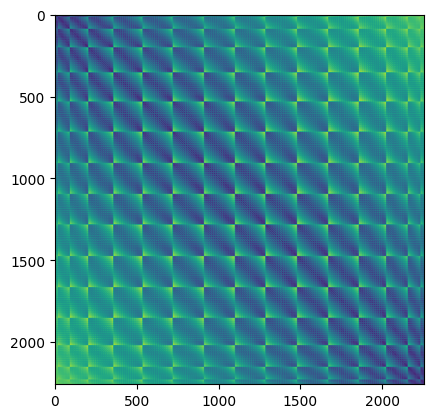

In [6]:
from scipy.spatial import distance_matrix
mat = np.array(np.nonzero(data)).T
source_geometry = distance_matrix(mat, mat)
target_geometry = source_geometry.copy()
plt.imshow(source_geometry)

In [7]:
import plotly.express as px

vertex_index = 0

fig = px.scatter_3d(x=mat[:,0], y=mat[:,1], z=mat[:,2], color=source_geometry[:,vertex_index])
fig.update_traces(marker_size = 5)
fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=True )
fig.show()

In [8]:
source_features = source_features[data].T
target_features = target_features[data].T

In [9]:
# Normalization
source_features_normalized = source_features / np.linalg.norm(
source_features, axis=1
).reshape(-1, 1)
target_features_normalized = target_features / np.linalg.norm(
    target_features, axis=1
).reshape(-1, 1)
source_geometry_normalized = source_geometry / np.max(source_geometry)
target_geometry_normalized = target_geometry / np.max(target_geometry)

In [11]:
# Mapping training
from fugw.mappings import FUGW
mapping = FUGW(alpha=0.5, rho=1, eps=1e-4)
_ = mapping.fit(
    source_features_normalized[:n_training_contrasts],
    target_features_normalized[:n_training_contrasts],
    source_geometry=source_geometry_normalized,
    target_geometry=target_geometry_normalized,
    solver="sinkhorn",
    solver_params={
        "nits_bcd": 3,
    },
    verbose=True,
)

[10:47:58] BCD step 1/3    FUGW loss:      0.021032018586993217 (base)     0.02176850475370884         ]8;id=785919;file:///Users/plbar/Research/fugw/src/fugw/solvers/dense.py\dense.py]8;;\:]8;id=664582;file:///Users/plbar/Research/fugw/src/fugw/solvers/dense.py#360\360]8;;\
           (entropic)                                                                                              

[10:48:32] BCD step 2/3    FUGW loss:      0.001891227555461228 (base)     0.00316063710488379         ]8;id=541461;file:///Users/plbar/Research/fugw/src/fugw/solvers/dense.py\dense.py]8;;\:]8;id=542116;file:///Users/plbar/Research/fugw/src/fugw/solvers/dense.py#360\360]8;;\
           (entropic)                                                                                              

[10:49:06] BCD step 3/3    FUGW loss:      0.001765415770933032 (base)     0.003059963695704937        ]8;id=16598;file:///Users/plbar/Research/fugw/src/fugw/solvers/dense.py\dense.py]8;;\:]8;id=438674;file:///Users/plbar/Research/fugw/src/fugw/solvers/dense.py#360\360]8;;\
           (entropic)                                                                                              

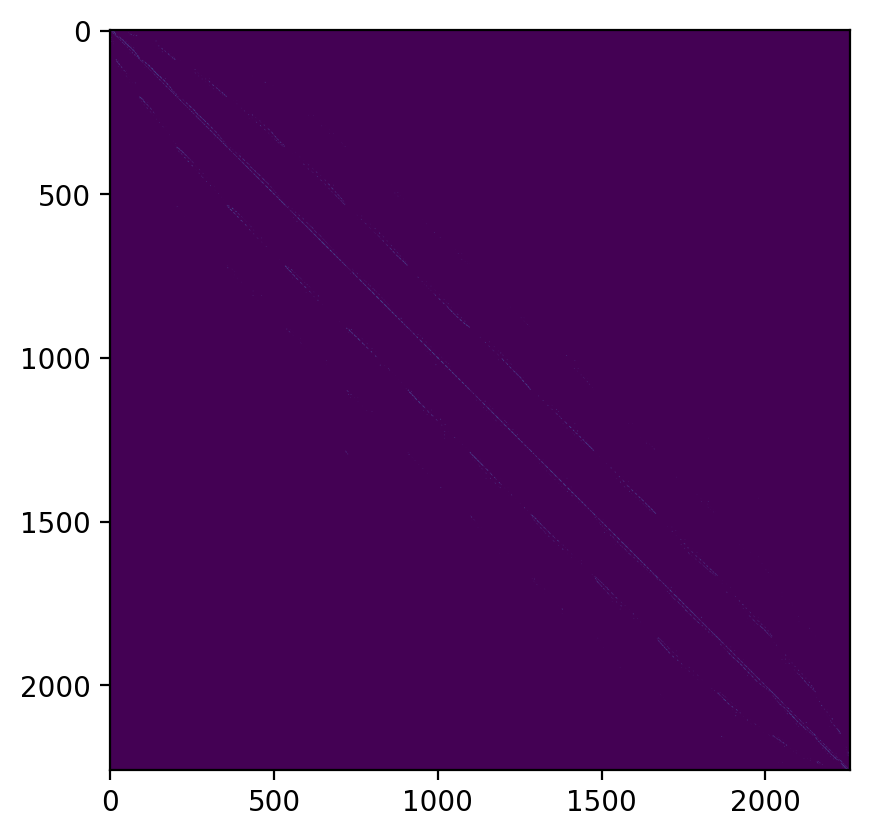

In [12]:
# Show mapping
pi = mapping.pi
import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 200
plt.imshow(pi, cmap='viridis')
plt.show()
plt.rcParams['figure.dpi'] = 100

In [13]:
# Reverse probability map
import plotly
vertex_index = 1700

probability_map = pi[vertex_index, :] / np.sqrt(np.linalg.norm(pi[vertex_index, :]))

fig = px.scatter_3d(x=mat[:,0], y=mat[:,1], z=mat[:,2], color=np.asarray(probability_map), 
                    color_continuous_scale=plotly.colors.sequential.Reds)
fig.update_traces(marker_size = 5)
fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
fig.show()

In [14]:
# Predict target features
contrast_index = -1
predicted_target_features = mapping.transform(
    source_features[contrast_index, :]
)
predicted_target_features.shape

(2258,)

In [15]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=3,
                    specs=[[{"type": "scene"}, {"type": "scene"}, {"type": "scene"}]],
                    subplot_titles=("Source contrast", "Predicted target", "Actual target"))

fig.add_trace(
    go.Scatter3d(x = mat[:,0], y = mat[:,1], z = mat[:,2], mode = 'markers', 
                marker = dict(size = 4, color = np.asarray(source_features[-1,:])),
                name="Source contrast"), 
    row=1, col=1
    )
fig.add_trace(
    go.Scatter3d(x = mat[:,0], y = mat[:,1], z = mat[:,2], mode = 'markers',
                marker = dict(size = 5, color = np.asarray(predicted_target_features)),
                name="Predicted target"), 
    row=1, col=2
    )
fig.add_trace(
    go.Scatter3d(x = mat[:,0], y = mat[:,1], z = mat[:,2], mode = 'markers', 
                marker = dict(size = 5, color = np.asarray(target_features[-1,:])),
                name="Actual target"), 
    row=1, col=3
    )
fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=True )
fig.show()


In [16]:
corr_pre_mapping = np.corrcoef(source_features[contrast_index, :], target_features[contrast_index, :])[0,1]
corr_post_mapping = np.corrcoef(predicted_target_features, target_features[contrast_index, :])[0,1]
print(f"Pearson Correlation pre-mapping: {corr_pre_mapping:.2f}")
print(f"Pearson Correlation post-mapping: {corr_post_mapping:.2f}")
print(f"Relative improvement: {(corr_post_mapping - corr_pre_mapping) / corr_pre_mapping *100 :.2f} %")

Pearson Correlation pre-mapping: 0.38
Pearson Correlation post-mapping: 0.43
Relative improvement: 12.68 %
